In [1]:
import pandas as pd
import numpy as np
import math
import time
import heapq
from queue import PriorityQueue
from collections import deque, defaultdict
from dataclasses import dataclass, field
from typing import Optional, Any

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='magma')

Фактически, симулятор - это несколько очередей: market (`md`, стакан в тик времени), actions (наши действия на рынке) и strategy updates (обновление состояние портфеля, идущее в стратегию). Поскольку симулятор скорее учебный и для личного понимания как всё устроено на очень базовом уровне, то и функционал и возможности симулятора ограничены. К примеру, никак не моделируется реакция рынка на действия агента (то есть нас).

Так же реализован класс `Strategy` для будущего тестирования стратегий и sanity check'а симулятора на примере стратегии со случайной торговлей в каждый момент времени.

In [2]:
@dataclass
class Order:  # Our own placed order
    timestamp: int
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class AnonTrade:  # Market trade
    timestamp: int
    side: str
    size: float
    price: str


@dataclass
class OwnTrade:  # Execution of own placed order
    timestamp: float
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    timestamp: int
    asks: list[tuple[int, int]]  # tuple[price, size]
    bids: list[tuple[int, int]]


@dataclass
class MdUpdate:  # Data of a tick
    timestamp: int
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trade: Optional[AnonTrade] = None

@dataclass(order=True)
class PrioritizedItem:
    priority: int
    item: Any = field(compare=False)
        
@dataclass
class OrderCanceler:
    timestamp: int
    order_id: int
        
class Strategy:
    def __init__(self, max_pos: float, maker_fee: float, t_0: int) -> None:
        self.max_pos = max_pos
        self.maker_fee = 0 # to change for future tasks
        self.t_0 = t_0 * int(1e6)
        self.active_orders = dict()
        self.best_bid = math.inf
        self.best_ask = math.inf
        self.current_pos = 0
        self.pnl = defaultdict(int, key=0)

    def is_mdupdate(self, action):
        return isinstance(action, MdUpdate)
    
    def is_owntrade(self, action):
        return isinstance(action, OwnTrade)
    
    def handle_update(self, md_update):
        if self.is_mdupdate(md_update):
            if md_update.orderbook == None:
                if md_update.trade.side == 'ASK':
                    self.best_ask = md_update.trade.price
                else:
                    self.best_bid = md_update.trade.price
            else:
                self.best_ask = md_update.orderbook.asks[0][0]
                self.best_bid = md_update.orderbook.bids[0][0]
        elif self.is_owntrade(md_update):
            if md_update.side == 'ASK':
                self.pnl[md_update.timestamp] += md_update.size * md_update.price
                self.best_ask = md_update.price
            else:
                self.pnl[md_update.timestamp] -= md_update.size * md_update.price
                self.best_bid = md_update.price
    
    def clean_timed_orders(self, timestamp, sim):
        to_clean = []
        for order_id in self.active_orders:
            if self.active_orders[order_id] + self.t_0 < timestamp:
                to_clean.append(order_id)
                sim.cancel_order(order_id, timestamp)
        for order_id in to_clean:
            self.active_orders.pop(order_id)
    
    def run(self, sim: "Sim", max_iter=1000):
        iters = 0
        while True:
            try:
                if iters >= max_iter:
                    return self.pnl
                
                update = sim.tick()
                self.handle_update(update)
                self.clean_timed_orders(update.timestamp, sim)
                
                side = np.random.choice(['ASK', 'BID'], size=1)
                size = np.random.uniform(0, np.abs(self.max_pos - self.current_pos))
                timestamp = update.timestamp + int(np.random.normal(100, 25, size=1)[0])
                if side == 'ASK' and self.current_pos > -self.max_pos and self.best_ask != math.inf:
                    price = self.best_ask
                    order_id = sim.place_order(timestamp, side, size, price)
                    self.active_orders[order_id] = timestamp
                elif side == 'BID' and self.current_pos < self.max_pos and self.best_bid != math.inf:
                    price = self.best_bid
                    order_id = sim.place_order(timestamp, side, size, price)
                    self.active_orders[order_id] = timestamp
                
                iters += 1
                
            except StopIteration:
                break

def transform_trades(trades, trades_cols):
    return list(map(lambda _: AnonTrade()))

def convert_snapshot(snapshot, cols):
    ask_prices_idxs = [i for i, col in enumerate(cols) if 'ask_price' in col]
    ask_sizes_idxs = [i for i, col in enumerate(cols) if 'ask_vol' in col]
    bid_prices_idxs = [i for i, col in enumerate(cols) if 'bid_price' in col]
    bid_sizes_idxs = [i for i, col in enumerate(cols) if 'bid_vol' in col]
    
    ask_prices = snapshot[ask_prices_idxs]
    ask_sizes = snapshot[ask_sizes_idxs]
    bid_prices = snapshot[bid_prices_idxs]
    bid_sizes = snapshot[bid_sizes_idxs]
    
    asks = list(map(tuple, np.vstack([ask_prices, ask_sizes]).T))
    bids = list(map(tuple, np.vstack([bid_prices, bid_sizes]).T))
    timestamp = snapshot[1] # exchange_ts
    
    return MdUpdate(timestamp, OrderbookSnapshotUpdate(timestamp, asks, bids), None)


def load_md_from_file(lobs_path: str, trades_path: str, chunksize: int):
    trades_iter = pd.read_csv(trades_path, skipinitialspace=True, chunksize=chunksize)
    lobs_iter = pd.read_csv(lobs_path, skipinitialspace=True, chunksize=chunksize)  
    md = {'trades': trades_iter, 'snapshots': lobs_iter}
    return md

def get_timestamp(item):
    return item.timestamp

class Sim:
    def __init__(self, execution_latency: float, md_latency: float,
                trades_path: str, lobs_path: str, chunksize = 1000) -> None:
        self.md = load_md_from_file(lobs_path, trades_path, chunksize)
        self.md_latency = md_latency
        self.execution_latency = execution_latency
        self.md_queue = deque()
        self.actions_queue = deque()
        self.active_orders = dict()
        self.strategy_updates_queue = PriorityQueue()
        self.best_ask = math.inf
        self.best_bid = 0
        self.order_id_free = 0
        self.latest_timestamp = 0
        
    def update_md_queue(self):
        try:
            trades = next(self.md['trades'])
            lobs = next(self.md['snapshots'])
            trades_cols = trades.columns
            lobs_cols = lobs.columns
            trades = trades.to_numpy()
            lobs = lobs.to_numpy()

            # 0 - receive_ts, 1 - exchange_ts, 2 - side
            # 3 - price, 4 - size
            trades = list(map(lambda x: MdUpdate(x[1], None, AnonTrade(x[1], x[2], x[4], x[3])), trades))
            snapshots = list(map(lambda x: convert_snapshot(x, lobs_cols), lobs))
            
            self.md_queue = deque(heapq.merge(trades, snapshots, key=get_timestamp))
            
        except StopIteration:
            return
        
    def tick(self) -> MdUpdate:
        while True:
            if len(self.md_queue) == 0:
                self.update_md_queue()
            
            md_event_time = self.md_queue[0].timestamp if len(self.md_queue) > 0 else math.inf
            actions_event_time = self.actions_queue[0].timestamp if len(self.actions_queue) > 0 else math.inf
            strategy_event_time = self.strategy_updates_queue.queue[0].priority if self.strategy_updates_queue.qsize() > 0 else math.inf
            self.latest_timestamp = min(md_event_time, actions_event_time, strategy_event_time)
            
            if md_event_time == math.inf and actions_event_time == math.inf and strategy_event_time == math.inf:
                break
            
            if md_event_time <= actions_event_time and md_event_time <= strategy_event_time:
                event = self.md_queue.popleft()
                timestamp = event.timestamp
                
                if event.orderbook == None:
                    trade = event.trade
                    if trade.side == 'ASK':
                        self.best_ask = trade.price
                    else:
                        self.best_bid = trade.price
                else:
                    snapshot = event.orderbook
                    self.best_ask = snapshot.asks[0][0]
                    self.best_bid = snapshot.bids[0][0]
                
                self.strategy_updates_queue.put(PrioritizedItem(-timestamp - self.md_latency, event))
                self.execute_orders()
            
            elif actions_event_time <= md_event_time and actions_event_time <= strategy_event_time:
                self.prepare_orders(self.actions_queue.popleft())
                self.execute_orders()
            else:
                return self.strategy_updates_queue.get().item

    def is_order(self, action):
        return isinstance(action, Order)
    
    def prepare_orders(self, action):
        if self.is_order(action):
            self.active_orders[action.order_id] = action
        else:
            self.active_orders.pop(action.order_id, None)

    def execute_orders(self):
        executed_orders = []
        merged_ask = dict()
        merged_bid = dict()
        
        for order_id in self.active_orders:
            order = self.active_orders[order_id]
            if order.side == 'ASK' and order.price <= self.best_bid:
                executed_orders.append(order_id)
                if order.price in merged_ask:
                    merged_ask[order.price].size += order.size
                else:
                    merged_ask[order.price] = OwnTrade(self.latest_timestamp + self.md_latency, order.order_id, 'ASK', order.size, order.price)
            elif order.side == 'BID' and order.price >= self.best_ask:
                executed_orders.append(order_id)
                if order.price in merged_bid:
                    merged_bid[order.price].size += order.size
                else:
                    merged_ask[order.price] = OwnTrade(self.latest_timestamp + self.md_latency, order.order_id, 'BID', order.size, order.price)
        
        for price in merged_ask:
            self.strategy_updates_queue.put(PrioritizedItem(-merged_ask[price].timestamp, merged_ask[price]))
        for price in merged_bid:
            self.strategy_updates_queue.put(PrioritizedItem(-merged_bid[price].timestamp, merged_bid[price]))
            
        for order_id in executed_orders:
            self.active_orders.pop(order_id)

    def place_order(self, timestamp, side, size, price):
        order_id = self.order_id_free
        self.order_id_free += 1
        order = Order(timestamp + self.execution_latency, order_id, side, size, price)
        self.actions_queue.append(order)
        return order_id

    def cancel_order(self, order_id, ts):
        self.actions_queue.append(OrderCanceler(ts, order_id))


In [3]:
def pnl_plot(pnl, coin):
    timestamps = []
    pnl_accum = []
    for timestamp in sorted(list(pnl.keys())[1:]):
        timestamps.append(timestamp)
        pnl_accum.append(pnl[timestamp])
    timestamps = pd.to_datetime(np.array(timestamps), unit='ns')
    pnl_accum = np.array(pnl_accum).cumsum()
    plt.figure(figsize=(12, 7))
    plt.plot(timestamps, pnl_accum)
    plt.xlim([min(timestamps), max(timestamps)])
    plt.xlabel('Timestamp')
    plt.ylabel('PnL')
    plt.title(f'{coin} PnL plot');

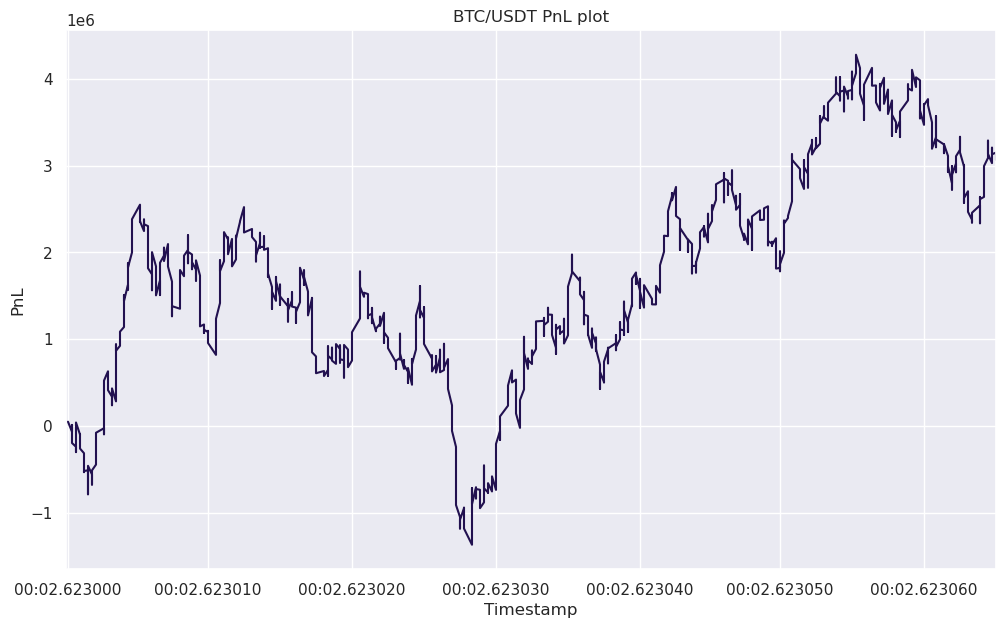

In [4]:
strategy = Strategy(10, 0, 50)
sim = Sim(20, 10, 'md/btcusdt:Binance:LinearPerpetual/trades.csv', 'md/btcusdt:Binance:LinearPerpetual/lobs.csv')
pnl = strategy.run(sim, 1000)

pnl_plot(pnl, 'BTC/USDT')

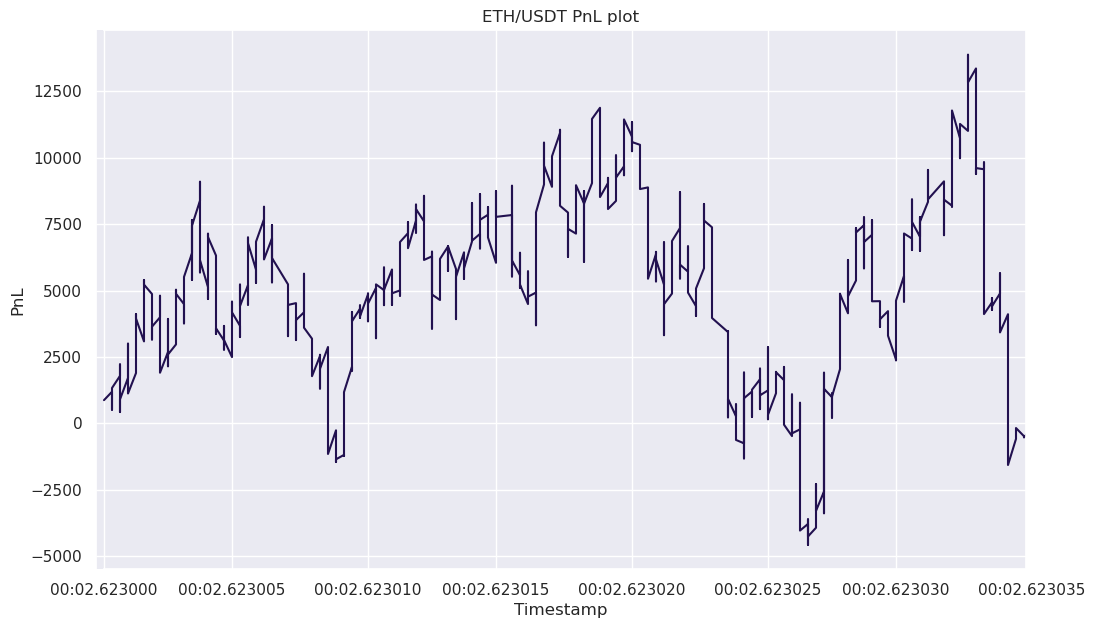

In [5]:
strategy = Strategy(1, 0, 10)
sim = Sim(20, 20, 'md/ethusdt:Binance:LinearPerpetual/trades.csv', 'md/ethusdt:Binance:LinearPerpetual/lobs.csv')
pnl = strategy.run(sim, 1000)

pnl_plot(pnl, 'ETH/USDT')